## discover optimal hyperparameters within a chosen method


## as demonstrated in scikit learn, run two levels of tests to discover an optimal cluster depth and initialisation

within your chosen, best method

In [8]:
from time import time
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [14]:
#define data as binned m2_pipeline

data = pd.read_csv('binned_pipeline.csv')

In [114]:
data = data.dropna()
# Splitting the dataframe into features and labels
X = data.drop(columns=['bin'])
y = data['bin']

# Performing the test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()

#use for fit, predict
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [76]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=1000,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

## run the benchmark via looped cluster setup

In [22]:
X_train.columns

Index(['Unnamed: 0', 'precursor_buy_cap_pct_change',
       'precursor_ask_cap_pct_change', 'precursor_bid_vol_pct_change',
       'precursor_ask_vol_pct_change', 'change.1', 'surge_targets_met_pct'],
      dtype='object')

In [77]:
csize = [2,3,4,5,6,7,8,9,10]

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

for i in range(len(csize)):
    n_digits= csize[i]
    print("for cluster size:", csize[i])

    kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=42)
    bench_k_means(kmeans=kmeans, name="k-means++", data=X_train_scaled, labels=y_train)

    kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=42)
    bench_k_means(kmeans=kmeans, name="random", data=X_train_scaled, labels=y_train)
    print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
for cluster size: 2
k-means++	0.016s	25315	0.001	0.023	0.002	0.003	0.000	0.732
random   	0.011s	25315	0.001	0.023	0.002	0.003	0.000	0.717
__________________________________________________________________________________
for cluster size: 3
k-means++	0.038s	22041	0.009	0.025	0.014	0.006	0.011	0.322
random   	0.015s	22024	0.009	0.024	0.013	0.006	0.010	0.301
__________________________________________________________________________________
for cluster size: 4
k-means++	0.021s	17533	0.009	0.025	0.014	0.005	0.010	0.303
random   	0.021s	19895	0.132	0.250	0.173	0.090	0.170	0.330
__________________________________________________________________________________
for cluster size: 5
k-means++	0.033s	14950	0.191	0.559	0.284	0.202	0.281	0.308
random   	0.016s	17091	0.172	0.297	0.218	0.107	0.214	0.358
____________________________________________________________

In [78]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
pca = PCA(n_components=2).fit(X_train_scaled)
kmeans = KMeans(init=pca.components_, n_clusters=2, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=X_train_scaled, labels=y_train)

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
PCA-based	0.009s	26966	0.008	0.023	0.011	0.003	0.010	0.280


### homogeneity measures
homogeneity between labeled clusters is at best random, 10 clusters. 

inertia is highest at PCA 2 clusters.

Completeness highest at kmeans++ at 5 clusters.

V-Measure highest at random, 10 clusters.

Adjusted Random highest at kmeans++/5 clusters.

Adjusted Mutual Information, highest at kmeans++ 5 clusters. 

Silhouette highest at kmeans++ clusters,2. 

## for PCA enabled clustering, visualisation

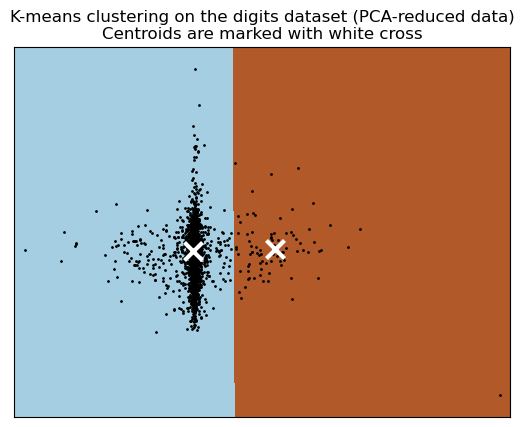

In [80]:
reduced_data = PCA(n_components=2).fit_transform(X_train_scaled)
kmeans = KMeans(init="k-means++", n_clusters=2, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Gaussian mixture model, to reflect our standardized column structure

In [102]:
# X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
gm = GaussianMixture(n_components=6, random_state=42).fit(X_train_scaled, y_train)
# print(gm.means_)
gm.predict(X_test_scaled)
gm.score(X_test_scaled, y_test)

-34.67493213943945

In [104]:
km = KMeans(n_clusters=2, init='k-means++', random_state=42,n_init='auto').fit(X_train_scaled, y_train)
km.predict(X_test_scaled)
km.score(X_test_scaled, y_test)

-6724.79411162226

In [99]:
km = KMeans(n_clusters=2, init='random', random_state=42).fit(X_train_scaled, y_train)
km.predict(X_test_scaled)
km.score(X_test_scaled, y_test)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


-6391.15132888848

## decisionability matrix

qualty by which each leading technique correctly separates negative and positive classes of profit, per bin structure. 

Potentially also distinguishes the value of yes trades, given the prediction result.

implement fit, transform, predict for the below methods. apply labels_ to all rows. get accuracy score

In [45]:
#firstly, take the topn methods

# groupby cluster and bin, then unique()

# does any bin possess bin labels which overlap?

# in general, is the clustering technique capable of separating positive and negative values, or yes or no trade conditions?

[[-0.94186057  0.01882552  0.02882919 ... -0.11998176  0.13010854
  -0.91166878]
 [ 1.31669354  0.00898589 -0.31204076 ... -1.06559378  0.10830159
   0.1820389 ]
 [-1.42177305  0.07655829  0.02850563 ... -0.08652971  0.18018744
  -1.00102726]
 ...
 [-0.28462858  0.13308825  0.01469726 ... -0.05088042 -4.23161254
   0.26707355]
 [-0.13575283 -0.61264197 -0.38343138 ... -1.19593015  0.1217974
  -0.93314595]
 [-0.05768384 -2.11740709 -1.81476979 ... -5.47239819  0.00763984
  -1.71445829]]


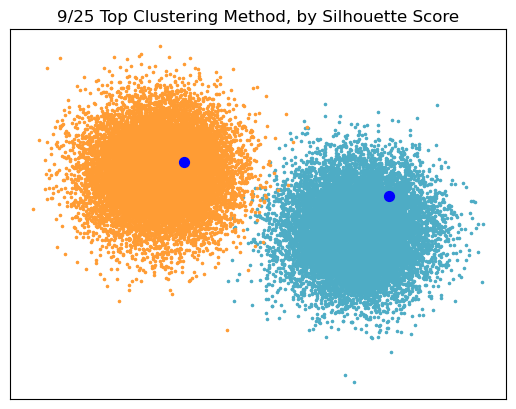

In [126]:
import matplotlib.pyplot as plt

from sklearn.cluster import kmeans_plusplus
from sklearn.datasets import make_blobs

# Generate sample data
n_samples = X_train_scaled.size
n_components = 2

X, y_true = make_blobs(
    n_samples=n_samples, centers=n_components, cluster_std=0.60, random_state=0
)
X = X[:, ::-1]

# Calculate seeds from k-means++
centers_init, indices = kmeans_plusplus(X, n_clusters=2, random_state=42)

# Plot init seeds along side sample data
plt.figure(1)
colors = ["#4EACC5", "#FF9C34", "#4E9A06", "m"]

for k, col in enumerate(colors):
    cluster_data = y_true == k
    plt.scatter(X[cluster_data, 0], X[cluster_data, 1], c=col, marker=".", s=10)

plt.scatter(centers_init[:, 0], centers_init[:, 1], c="b", s=50)
plt.title("9/25 Top Clustering Method, by Silhouette Score")
plt.xticks([])
plt.yticks([])
plt.show()
